(312, 452)
(312, 452, 3)


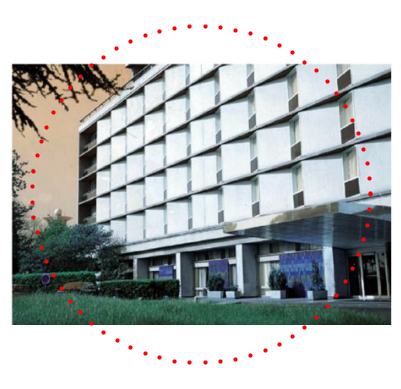

In [82]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools
from image_processing import ImageProcessor
from typing import Tuple

# Read the image
imgg_instance = ImageProcessor("F:\computer_vision_task_1\Images\Screenshot 2023-03-12 130443.jpg")
image = cv2.imread("F:\computer_vision_task_1\Images\Screenshot 2023-03-12 130443.jpg")  # Replace "image_path.jpg" with the path to your image file
radius = 200
N_points= 70
# this function returns just the new position of the contour point
def iterate_contour(source: np.ndarray, contour_x: np.ndarray, contour_y: np.ndarray,
                    external_energy: np.ndarray, window_coordinates: list,
                    alpha: float, beta: float) -> Tuple[np.ndarray, np.ndarray]:
    src = np.copy(source)
    cont_x = np.copy(contour_x)
    cont_y = np.copy(contour_y)
    contour_points = len(cont_x) #reterns scalers of 60 
    for Point in range(contour_points):# point takes the value from 0 to 59
        MinEnergy = np.inf
        TotalEnergy = 0
        NewX = None
        NewY = None
        #this for loops aims to update the position of the contour point
        for Window in window_coordinates: # (x,y) window[0]--> 43
            # Create Temporary Contours With Point Shifted To A Coordinate
            CurrentX, CurrentY = np.copy(cont_x), np.copy(cont_y)
            CurrentX[Point] = CurrentX[Point] + Window[0] if (CurrentX[Point] < src.shape[1]) else src.shape[1] - 1 # shape[1]--> x axis
            CurrentY[Point] = CurrentY[Point] + Window[1] if CurrentY[Point] < src.shape[0] else src.shape[0] - 1
            # Calculate Energy At The New Point
            try:
                TotalEnergy = external_energy[CurrentY[Point], CurrentX[Point]] + calculate_internal_energy(CurrentX,
                                                                                                            CurrentY,
                                                                                                            alpha,
                                                                                                            beta)
            except:
                pass
            # Save The Point If It Has The Lowest Energy In The Window
            if TotalEnergy < MinEnergy:
                MinEnergy = TotalEnergy
                NewX = CurrentX[Point] if CurrentX[Point] < src.shape[1] else src.shape[1] - 1
                NewY = CurrentY[Point] if CurrentY[Point] < src.shape[0] else src.shape[0] - 1
        # Shift The Point In The Contour To It's New Location With The Lowest Energy
        cont_x[Point] = NewX
        cont_y[Point] = NewY
    return cont_x, cont_y


def create_contour():
    height, width, _ = image.shape
    center_x = width // 2
    center_y = height // 2
    angles = np.linspace(0, 2*np.pi, N_points)
    x_coordinates = center_x + radius* np.cos(angles)
    y_coordinates = center_y + radius * np.sin(angles)
    contour_x = x_coordinates.astype(int)
    contour_y = y_coordinates.astype(int)
    window =GenerateWindowCoordinates(3)
    return contour_x,contour_y , window
    

def GenerateWindowCoordinates(Size):
        # Generate List of All Possible Point Values Based on Size
        Points = list(range(-Size // 2 + 1 , Size // 2 + 1))
        PointsList = [Points, Points]

        # Generates All Possible Coordinates Inside The Window
        Coordinates = list(itertools.product(*PointsList))
        return Coordinates

def calculate_internal_energy(CurrentX, CurrentY, alpha: float, beta: float):
    JoinedXY = np.array((CurrentX, CurrentY))
    # list of list inner list represent the point(x,y) and the outer one represents all points
    Points = JoinedXY.T
    # Continuous  Energy
    PrevPoints = np.roll(Points, 1, axis=0)
    NextPoints = np.roll(Points, -1, axis=0)
    Displacements = Points - PrevPoints
    # computes the Euclidean distance between each pair of adjacent points.
    PointDistances = np.sqrt(Displacements[:, 0] ** 2 + Displacements[:, 1] ** 2)
    MeanDistance = np.mean(PointDistances)
    ContinuousEnergy = np.sum((PointDistances - MeanDistance) ** 2)
    # Curvature Energy
    CurvatureSeparated = PrevPoints - 2 * Points + NextPoints
    Curvature = (CurvatureSeparated[:, 0] ** 2 + CurvatureSeparated[:, 1] ** 2)
    CurvatureEnergy = np.sum(Curvature)
    return (alpha * ContinuousEnergy + beta * CurvatureEnergy)
    
def calculate_external_energy(source):
    src = np.copy(source)
    # convert to gray scale if not already
    if len(src.shape) > 2:
        gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    else:
        gray = src
    # Apply Gaussian Filter to smooth the image
    Gaussian_image = imgg_instance.apply_gaussian_filter( gray,  7,  7)
    # Get Gradient Magnitude & Direction
    # Compute the gradient using the Sobel operator
    gradient_x= cv2.Sobel(Gaussian_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y=cv2.Sobel(Gaussian_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    # Normalize the gradient magnitude to range [0, 1]
    #gradient_magnitude = gradient_magnitude / np.max(gradient_magnitude)
    # Calculate the external energy
    gamma= 0.5
    shape=image.shape
    pad_width = ((0, shape[0] - gradient_magnitude.shape[0]),  # Padding along rows
             (0, shape[1] - gradient_magnitude.shape[1]))  # Padding along columns

# Pad the array with zeros
    padded_array_2d = np.pad(gradient_magnitude, pad_width, mode='constant')

    external_energy = -gamma * padded_array_2d
    return external_energy


def calculate_external_energy_2(source, WLine = 0.001, WEdge=0.001):
    src = np.copy(source)
    # convert to gray scale if not already
    if len(src.shape) > 2:
        gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    else:
        gray = src
    # Apply Gaussian Filter to smooth the image
    ELine = imgg_instance.apply_gaussian_filter(gray, 7,  7)
    # Get Gradient Magnitude & Direction
    EEdge = cv2.Sobel(ELine, cv2.CV_64F, 1, 1, ksize=3)
    EEdge = EEdge / np.max(EEdge)

    return WLine * np.sum(ELine) 



contour_x,contour_y , window =create_contour()



# print(contour_x.shape )
# print(contour_y.shape)
# faro7a = calculate_internal_energy(contour_x,contour_y, 1, 1)
# print(faro7a)
external_energy= calculate_external_energy(image)
print(external_energy.shape )
# print(external_energy[50:80 , 1:5])
print(image.shape)
fig, ax = plt.subplots()
ax.imshow(image)
ax.plot(contour_x, contour_y, 'ro', markersize=2)
ax.axis('off')  # Turn off axis labels
plt.show()